# Payload SIREN - Projeto Jupiter

O objetivo da análise é investigar as condições térmicas, pressóricas e mecânicas (aceleração) experienciados no lançamento de um foguete experimental lançado pelo Projeto Jupiter (USP), durante a competição da IREC 2025 (Spaceport America, Texas), com apogeu estimado de 3.000 metros.

O Payload SIREN tem como objetivo avaliar a integridade das propriedades fisico-químicas do secretoma derivado de células tronco mesenquimais do perióstio, sob diferentes métodos de preservação em um contexto de aplicações espaciais. Os dados foram coletados por dois sensores BMP280 (pressão e temperatura), um deles posicionado na PCB e o outro acoplado dentro da estrutura de isopor(isolante térmico) que envolviam as amostras, e um IMU6050 (aceleração tri-axial), conectados a um raspberry pi pico.

### 1 - Importando Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 2 - Importando dados

In [2]:
# Carregando o CSV sem criar índice automático
df = pd.read_csv('Dados de voo segundo dia.csv' ,skipinitialspace=True, index_col=False, engine='python')
df.columns = df.columns.str.strip()

/tmp/ipython-input-2-3140441499.py:2: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv('Dados de voo segundo dia.csv' ,skipinitialspace=True, index_col=False, engine='python')


In [3]:
df.head()

,n,tempo_s,temp1_C,press1,temp2_C,press2,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
0,1,0.00,22.62,912.19,21.68,912.53,0.11,0.02,0.96,0.64,-2.01,-0.77
1,2,0.99,22.62,912.21,21.69,912.53,0.10,0.03,0.94,-0.22,-1.73,-0.73
2,3,1.99,22.63,912.22,21.69,912.49,0.10,0.03,0.96,0.84,-2.53,-0.63
3,4,2.99,22.63,912.23,21.69,912.53,0.10,0.03,0.95,-0.47,-1.56,-0.65
4,5,3.99,22.63,912.21,21.69,912.51,0.11,0.04,0.98,0.99,-2.34,-0.82


In [4]:
df.dtypes

,0
n,int64
tempo_s,float64
temp1_C,float64
press1,float64
temp2_C,float64
press2,float64
accel_x,float64
accel_y,float64
accel_z,float64
gyro_x,float64


### 3 - Análise Descritiva

In [5]:
df.describe()

,n,tempo_s,temp1_C,press1,temp2_C,press2,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z
count,193380.000000,193380.000000,193380.000000,193380.000000,193380.000000,193380.000000,193380.000000,193380.000000,193380.000000,193380.000000,193380.000000,193380.000000
mean,96660.795858,73086.569455,38.081037,896.598330,39.380546,896.548876,0.090674,0.686925,-0.274326,0.763289,-2.255809,2.604086
std,55816.743996,47592.897238,12.513890,49.817862,11.633902,49.797560,0.275961,0.522295,0.550557,8.951182,8.326111,35.564201
min,1.000000,0.000000,19.370000,638.400000,20.990000,638.500000,-16.000000,-16.000000,-10.990000,-250.140000,-250.140000,-250.140000
25%,48325.750000,23261.597500,24.240000,909.010000,26.350000,908.800000,0.050000,0.120000,-0.390000,0.330000,-2.210000,-0.580000
50%,96670.500000,74406.230000,39.710000,910.730000,41.370000,910.720000,0.050000,1.010000,-0.010000,0.460000,-2.080000,-0.180000
75%,145015.250000,125659.427500,50.560000,912.340000,49.560000,912.400000,0.060000,1.010000,-0.010000,0.610000,-1.970000,0.280000
max,193299.000000,133834.800000,58.490000,914.630000,59.750000,914.730000,16.000000,16.000000,16.000000,250.130000,250.130000,250.130000


In [6]:
# Calcular intervalos de tempo entre amostras e frequência de aquisição
intervalos = df['tempo_s'].diff().dropna()
frequencias = 1 / intervalos
# Classificar os modos com base na taxa de amostragem
limiar_voo = 50   # Hz
limiar_normal = 2 # Hz

modo = pd.Series(index=frequencias.index, dtype="object")
modo[frequencias < limiar_normal] = 'normal'
modo[frequencias >= limiar_voo] = 'voo'
display(intervalos)

,tempo_s
1,0.99
2,1.00
3,1.00
4,1.00
5,1.04
...,...
193375,0.03
193376,0.02
193377,0.02
193378,0.01


In [7]:
# Agrupar os índices por modo
resultados = []
for categoria in ['normal', 'voo']:
    indices = modo[modo == categoria].index
    if len(indices) == 0:
        continue

    tempo_inicio = df.loc[indices[0], 'tempo_s']
    # Fix: Access tempo_s using the last index of the modo series directly
    tempo_fim = df.loc[indices[-1], 'tempo_s']

    duracao = tempo_fim - tempo_inicio
    freq_modo = frequencias[indices]

    resultados.append({
        'Modo': categoria,
        'Registros': len(indices),
        'Duração (s)': duracao,
        'Frequência média (Hz)': freq_modo.mean(),
        'Desvio padrão (Hz)': freq_modo.std()
    })

In [8]:
# Mostrar resultado em tabela
df_modos = pd.DataFrame(resultados)
display(df_modos)

,Modo,Registros,Duração (s),Frequência média (Hz),Desvio padrão (Hz)
0,normal,125220,133547.95,0.944911,0.013475
1,voo,47527,122846.18,76.589097,24.949707


In [9]:
# Saltos Temporais
df['tempo_s'] = pd.to_numeric(df['tempo_s'], errors='coerce')
df.dropna(subset=['tempo_s'], inplace=True)

# Calcular intervalos entre registros
df['intervalo'] = df['tempo_s'].diff()

# Calcular frequência de aquisição (Hz)
df['frequencia'] = 1 / df['intervalo']

# Classificar modo de operação
def classificar_modo(freq):
    if freq >= 50:
        return 'voo'
    elif freq < 2:
        return 'normal'
    else:
        return 'intermediario'

df['modo'] = df['frequencia'].apply(classificar_modo)

intervalos_esperados = {
    'normal': 1.0,     # 1 segundo entre amostras (1 Hz)
    'voo': 0.02        # 0.02 s entre amostras (50 Hz)
}

# Verificar saltos temporais por modo
df['salto'] = False
for modo, intervalo_padrao in intervalos_esperados.items():
    mask = df['modo'] == modo
    saltos = df.loc[mask & (df['intervalo'] > 2 * intervalo_padrao)]
    df.loc[saltos.index, 'salto'] = True

# Mostrar resumo
saltos_detectados = df[df['salto']]
print(f"Total de saltos temporais detectados: {len(saltos_detectados)}")
print("\nsaltos detectados:")
print(saltos_detectados[['tempo_s', 'intervalo', 'modo']].head())


Total de saltos temporais detectados: 2

saltos detectados:
          tempo_s  intervalo    modo
37202    11490.92       2.21  normal
177067  132149.80       2.25  normal


### Análise da Aquisição de Dados e Modos de Operação

---

A missão totalizou **193.380 registros** de dados ao longo de aproximadamente **2230 minutos** (~37 horas) de operação. O **intervalo médio entre amostras foi de 0,69 segundos**, o que indica uma coleta contínua em sua maior parte. Foram identificados apenas **2 saltos temporais superiores ao dobro do intervalo médio**, sugerindo que a aquisição de dados ocorreu de forma estável e sem perdas significativas.

Houveram dois modos com diferentes taxas de amostragem, modo normal = 1 hz e modo voo = 50hz. Essa distinção visa otimizar o tempo de operação do payload com memória de armazenamento limitada (16mb raspberry pi pico). Para efeito de análise, foi considerado modo normal taxas de amostragem menor que 2hz.

- **Modo normal:** frequência < 2 Hz  
- **Modo voo:** frequência ≥ 50 Hz    

A classificação dos registros resultou na seguinte segmentação:

| Modo         | Registros | Duração (s) | Freq. média (Hz) | Desvio padrão (Hz) |
|--------------|-----------|-------------|------------------|---------------------|
| Modo normal  | 125.220   | 133.547,45  | 0,94             | 0,013               |
| Modo voo     | 47.527    | 122846,18  | 76,59            | 24,94               |

Os dados confirmam que o sistema foi capaz de **aumentar a taxa de aquisição de forma significativa durante a detecção de modo voo**, como previsto no design da missão. O modo voo atingiu uma **frequência média de 76,59 Hz**, com picos de até 100 Hz em alguns trechos. Já o modo normal manteve uma taxa próxima a **1 Hz**, ideal para economia de energia e armazenamento em solo.

Esses resultados evidenciam que a lógica de controle embarcada respondeu adequadamente às condições da missão, alternando entre os modos de forma funcional. Isso reforça a confiabilidade do sistema para aplicações futuras em ambientes extremos ou missões com restrições operacionais.


###Derivada da pressão no tempo
Durante o voo, a pressão atmosférica varia intensamente em função da altitude. Esses dados de pressão são essenciais para reconstruir eventos críticos do perfil de voo (como o lançamento, o apogeu e o início da queda) mas a simples observação da curva de pressão nem sempre é suficiente para identificar esses momentos com precisão.

Para isso, utilizamos a derivada temporal da pressão (dP/dt), que representa a taxa de variação da pressão ao longo do tempo.



In [10]:
#derivada da pressão no tempo
df['pressao_derivada'] = np.gradient(df['press1'], df['tempo_s'])

limiar_subida = -0.5
limiar_descida = 0.2

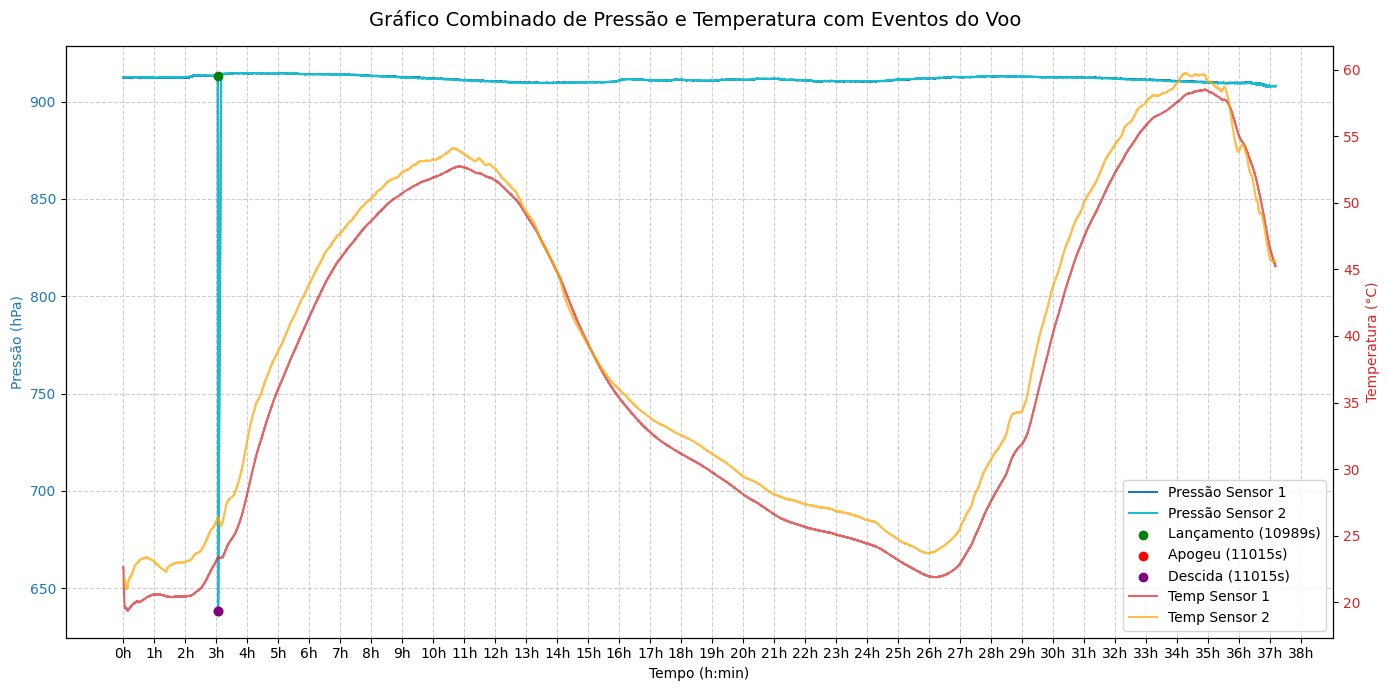

Início da subida: 10988.61 segundos
Apogeu (menor pressão): 11014.77 segundos
Início da queda: 11014.77 segundos


In [11]:
# Lançamento
inicio_subida = df[df['pressao_derivada'] < limiar_subida]['tempo_s'].iloc[0]

# Apogeu
indice_apogeu = df['press1'].idxmin()
tempo_apogeu = df.loc[indice_apogeu, 'tempo_s']

# Início da descida
df_pos_apogeu = df.loc[indice_apogeu:]
inicio_descida = df_pos_apogeu[df_pos_apogeu['pressao_derivada'] > limiar_descida]['tempo_s'].iloc[0]

fig, ax1 = plt.subplots(figsize=(14, 7))

# Pressões
ax1.set_xlabel('Tempo (h:min)')
ax1.set_ylabel('Pressão (hPa)', color='tab:blue')
ax1.plot(df['tempo_s'], df['press1'], label='Pressão Sensor 1', color='tab:blue')
ax1.plot(df['tempo_s'], df['press2'], label='Pressão Sensor 2', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Marcar eventos
ax1.scatter(inicio_subida, df.loc[df['tempo_s'] == inicio_subida, 'press1'].values[0],
            color='green', label=f'Lançamento ({inicio_subida:.0f}s)', zorder=5)
ax1.scatter(tempo_apogeu, df.loc[df['tempo_s'] == tempo_apogeu, 'press1'].values[0],
            color='red', label=f'Apogeu ({tempo_apogeu:.0f}s)', zorder=5)
ax1.scatter(inicio_descida, df.loc[df['tempo_s'] == inicio_descida, 'press1'].values[0],
            color='purple', label=f'Descida ({inicio_descida:.0f}s)', zorder=5)

# Grid de hora em hora
max_time = df['tempo_s'].max()
x_ticks = np.arange(0, max_time + 3600, 3600)
x_labels = [f"{int(t//3600)}h" for t in x_ticks]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels)

ax1.grid(True, which='both', linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.set_ylabel('Temperatura (°C)', color='tab:red')
ax2.plot(df['tempo_s'], df['temp1_C'], label='Temp Sensor 1', color='tab:red', alpha=0.7)
ax2.plot(df['tempo_s'], df['temp2_C'], label='Temp Sensor 2', color='orange', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='tab:red')


fig.suptitle('Gráfico Combinado de Pressão e Temperatura com Eventos do Voo', fontsize=14)
fig.tight_layout()
fig.legend(loc='lower right', bbox_to_anchor=(1, 0), bbox_transform=ax1.transAxes)
plt.show()

print(f"Início da subida: {inicio_subida:.2f} segundos")
print(f"Apogeu (menor pressão): {tempo_apogeu:.2f} segundos")
print(f"Início da queda: {inicio_descida:.2f} segundos")


Picos de variação (> 2°C/s) para temp1_C:
Total de picos detectados: 0

Picos de variação (> 2°C/s) para temp2_C:
Total de picos detectados: 0


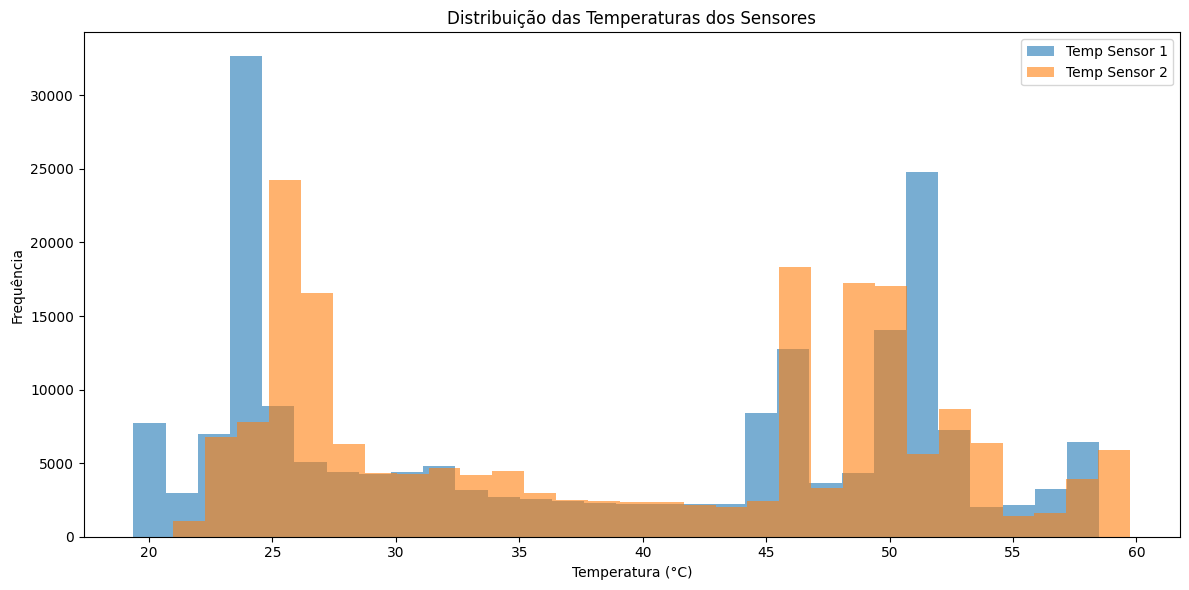

In [12]:
for sensor in ['temp1_C', 'temp2_C']:
    # Garantir que os dados estão em formato numérico
    df[sensor] = pd.to_numeric(df[sensor], errors='coerce')
    df['tempo_s'] = pd.to_numeric(df['tempo_s'], errors='coerce')

    # Remover valores ausentes que possam ter surgido com .to_numeric()
    df = df.dropna(subset=[sensor, 'tempo_s'])

    # Calcular derivada (dT/dt)
    taxa_variacao = np.gradient(df[sensor].values, df['tempo_s'].values)
    df[f'derivada_{sensor}'] = taxa_variacao

    # Detectar picos térmicos
    picos = df[np.abs(taxa_variacao) > 2]

    print(f"\nPicos de variação (> 2°C/s) para {sensor}:")
    print(f"Total de picos detectados: {len(picos)}")
    if not picos.empty:
        print(picos[['tempo_s', sensor, f'derivada_{sensor}']].head())


#Histograma das temperaturas (distribuição)
plt.figure(figsize=(12, 6))
plt.hist(df['temp1_C'], bins=30, alpha=0.6, label='Temp Sensor 1')
plt.hist(df['temp2_C'], bins=30, alpha=0.6, label='Temp Sensor 2')
plt.title('Distribuição das Temperaturas dos Sensores')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Frequência')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretação Comparativa

O Sensor 2 apresentou valores de média e mediana ligeiramente superiores aos do Sensor 1. Esse comportamento é coerente com a sua posição mais exposta ao calor, localizada fora da estrutura de isolamento térmico em isopor que envolvia a estrutura dos recipientes falcon tubes em que o secretoma esteve armazenado.

A amplitude térmica observada foi considerável em ambos os sensores, e o desvio padrão elevado (acima de 11 °C) reforça que as amostras estiveram submetidas a um ambiente com variação térmica relevante, resposta à exposição prolongada a luz do sol direta.

Esses resultados são fundamentais para a posterior avaliação da integridade das amostras expostas ao voo, especialmente em comparação com os grupos controle mantidos em solo. A análise térmica oferece suporte quantitativo para validar a eficácia das estratégias de proteção adotadas, como o uso de isolamento e a presença de trealose como agente estabilizante.

In [14]:
df_4h = df[df['tempo_s'] <= 14400]
df_4h.head()

,n,tempo_s,temp1_C,press1,temp2_C,press2,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,intervalo,frequencia,modo,salto,pressao_derivada,derivada_temp1_C,derivada_temp2_C
0,1,0.00,22.62,912.19,21.68,912.53,0.11,0.02,0.96,0.64,-2.01,-0.77,NaN,NaN,intermediario,False,0.020202,0.000000e+00,1.010101e-02
1,2,0.99,22.62,912.21,21.69,912.53,0.10,0.03,0.94,-0.22,-1.73,-0.73,0.99,1.010101,normal,False,0.015127,4.974874e-03,5.075884e-03
2,3,1.99,22.63,912.22,21.69,912.49,0.10,0.03,0.96,0.84,-2.53,-0.63,1.00,1.000000,normal,False,0.010000,5.000000e-03,1.776357e-15
3,4,2.99,22.63,912.23,21.69,912.53,0.10,0.03,0.95,-0.47,-1.56,-0.65,1.00,1.000000,normal,False,-0.005000,-1.776357e-15,-1.776357e-15
4,5,3.99,22.63,912.21,21.69,912.51,0.11,0.04,0.98,0.99,-2.34,-0.82,1.00,1.000000,normal,False,-0.014910,1.776357e-15,-4.713424e-03


/tmp/ipython-input-15-1201997750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4h['pressao_derivada'] = np.gradient(df_4h['press1'], df_4h['tempo_s'])


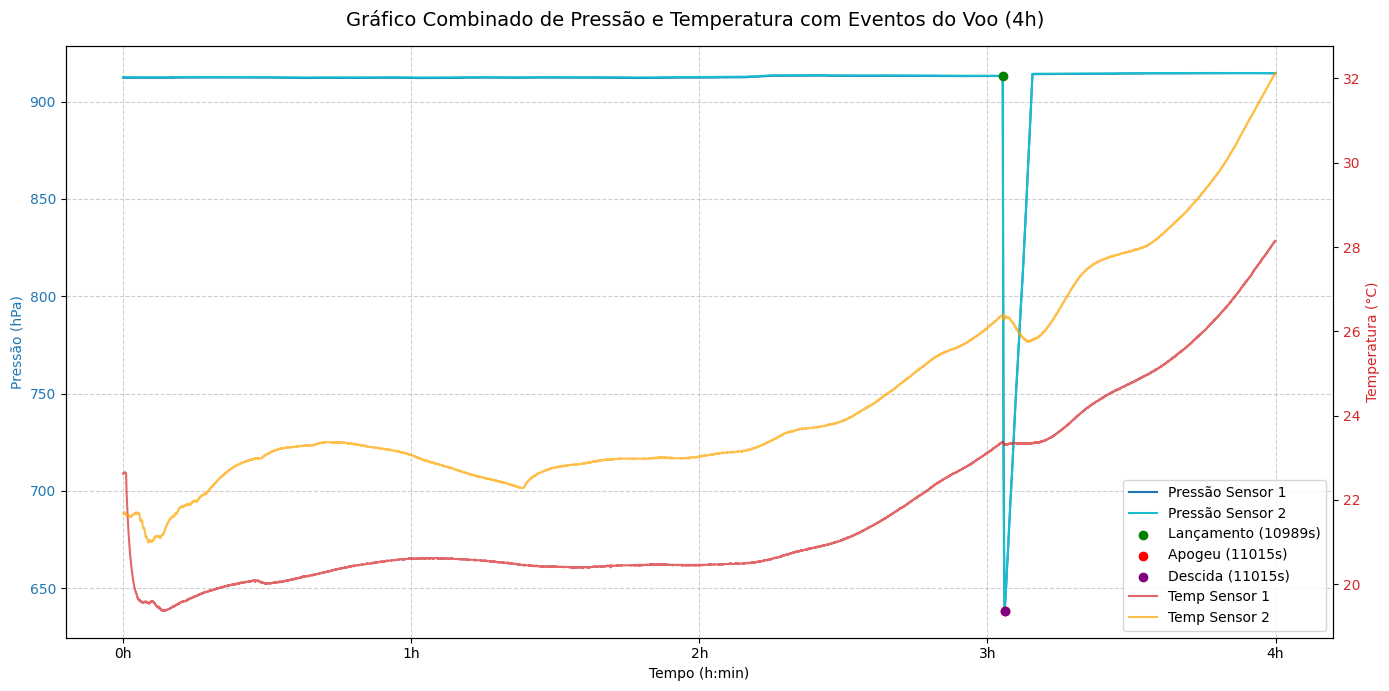

In [15]:
#Gráfico temperatura e pressao dos sensores, tempo 4h

df_4h['pressao_derivada'] = np.gradient(df_4h['press1'], df_4h['tempo_s'])

limiar_subida = -0.5
limiar_descida = 0.2

inicio_subida = df_4h[df_4h['pressao_derivada'] < limiar_subida]['tempo_s'].iloc[0]

indice_apogeu = df_4h['press1'].idxmin()
tempo_apogeu = df_4h.loc[indice_apogeu, 'tempo_s']

df_pos_apogeu = df_4h.loc[indice_apogeu:]
inicio_descida = df_pos_apogeu[df_pos_apogeu['pressao_derivada'] > limiar_descida]['tempo_s'].iloc[0]

fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Tempo (h:min)')
ax1.set_ylabel('Pressão (hPa)', color='tab:blue')
ax1.plot(df_4h['tempo_s'], df_4h['press1'], label='Pressão Sensor 1', color='tab:blue')
ax1.plot(df_4h['tempo_s'], df_4h['press2'], label='Pressão Sensor 2', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Marcar eventos
ax1.scatter(inicio_subida, df_4h.loc[df_4h['tempo_s'] == inicio_subida, 'press1'].values[0],
            color='green', label=f'Lançamento ({inicio_subida:.0f}s)', zorder=5)
ax1.scatter(tempo_apogeu, df_4h.loc[df_4h['tempo_s'] == tempo_apogeu, 'press1'].values[0],
            color='red', label=f'Apogeu ({tempo_apogeu:.0f}s)', zorder=5)
ax1.scatter(inicio_descida, df_4h.loc[df_4h['tempo_s'] == inicio_descida, 'press1'].values[0],
            color='purple', label=f'Descida ({inicio_descida:.0f}s)', zorder=5)

max_time = df_4h['tempo_s'].max()
x_ticks = np.arange(0, max_time + 3600, 3600)
x_labels = [f"{int(t//3600)}h" for t in x_ticks]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels)

ax1.grid(True, which='both', linestyle='--', alpha=0.6)

ax2 = ax1.twinx()
ax2.set_ylabel('Temperatura (°C)', color='tab:red')
ax2.plot(df_4h['tempo_s'], df_4h['temp1_C'], label='Temp Sensor 1', color='tab:red', alpha=0.7)
ax2.plot(df_4h['tempo_s'], df_4h['temp2_C'], label='Temp Sensor 2', color='orange', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='tab:red')


fig.suptitle('Gráfico Combinado de Pressão e Temperatura com Eventos do Voo (4h)', fontsize=14)
fig.tight_layout()
fig.legend(loc='lower right', bbox_to_anchor=(1, 0), bbox_transform=ax1.transAxes)
plt.show()

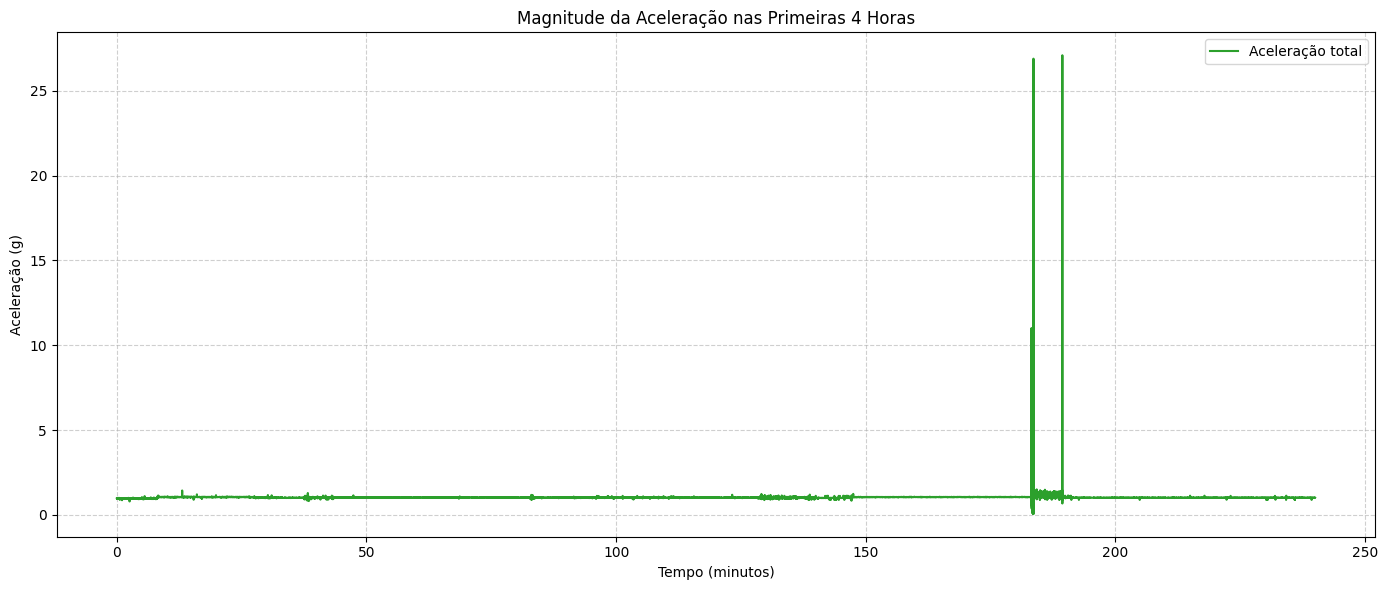

In [18]:

df['acel_magnitude'] = np.sqrt(df['accel_x']**2 + df['accel_y']**2 + df['accel_z']**2)

plt.figure(figsize=(14, 6))
plt.plot(df_4h['tempo_s'] / 60, df_4h['acel_magnitude'], color='tab:green', label='Aceleração total')

plt.xlabel("Tempo (minutos)")
plt.ylabel("Aceleração (g)")
plt.title("Magnitude da Aceleração nas Primeiras 4 Horas")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

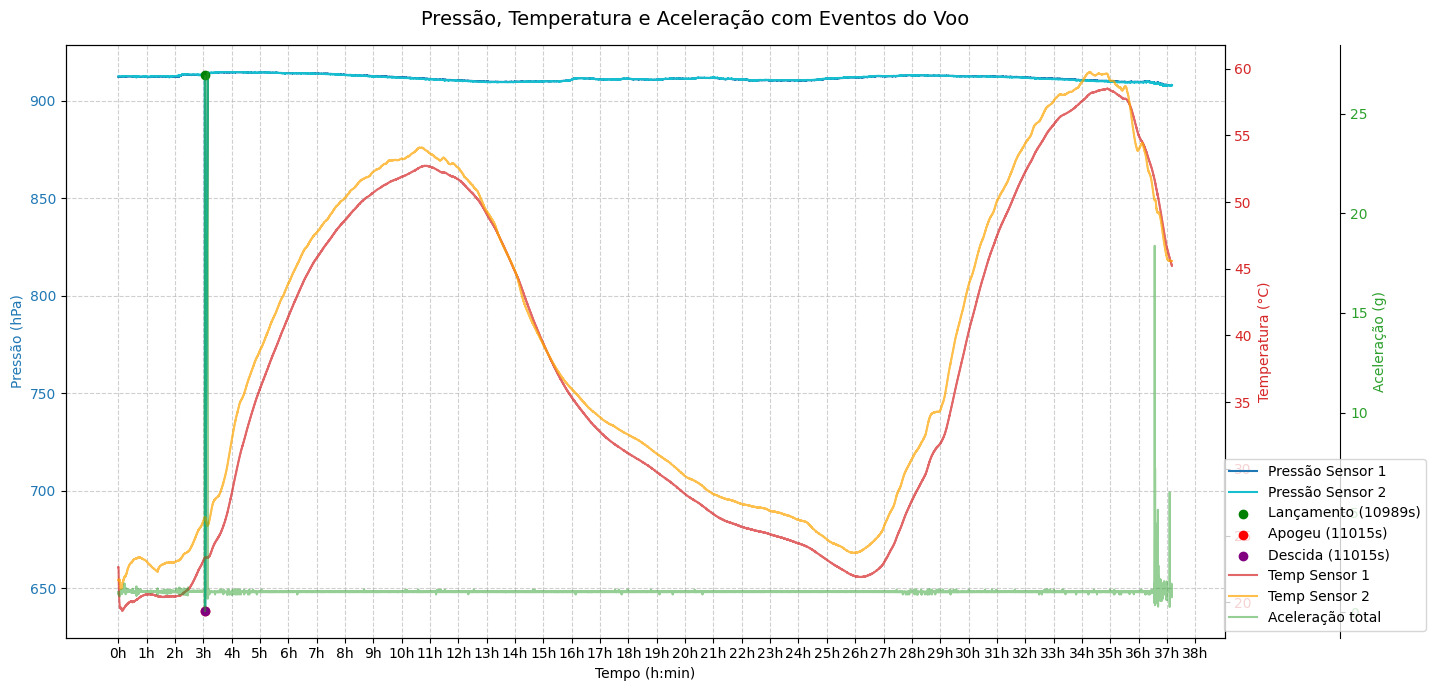

Início da subida: 10988.61 segundos
Apogeu (menor pressão): 11014.77 segundos
Início da queda: 11014.77 segundos


In [19]:
# Eventos de voo
inicio_subida = df[df['pressao_derivada'] < limiar_subida]['tempo_s'].iloc[0]
indice_apogeu = df['press1'].idxmin()
tempo_apogeu = df.loc[indice_apogeu, 'tempo_s']
df_pos_apogeu = df.loc[indice_apogeu:]
inicio_descida = df_pos_apogeu[df_pos_apogeu['pressao_derivada'] > limiar_descida]['tempo_s'].iloc[0]

# Plot com 3 eixos
fig, ax1 = plt.subplots(figsize=(14, 7))

# Eixo 1: Pressão
ax1.set_xlabel('Tempo (h:min)')
ax1.set_ylabel('Pressão (hPa)', color='tab:blue')
ax1.plot(df['tempo_s'], df['press1'], label='Pressão Sensor 1', color='tab:blue')
ax1.plot(df['tempo_s'], df['press2'], label='Pressão Sensor 2', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Eventos
ax1.scatter(inicio_subida, df.loc[df['tempo_s'] == inicio_subida, 'press1'].values[0],
            color='green', label=f'Lançamento ({inicio_subida:.0f}s)', zorder=5)
ax1.scatter(tempo_apogeu, df.loc[df['tempo_s'] == tempo_apogeu, 'press1'].values[0],
            color='red', label=f'Apogeu ({tempo_apogeu:.0f}s)', zorder=5)
ax1.scatter(inicio_descida, df.loc[df['tempo_s'] == inicio_descida, 'press1'].values[0],
            color='purple', label=f'Descida ({inicio_descida:.0f}s)', zorder=5)

# Grade por hora
max_time = df['tempo_s'].max()
x_ticks = np.arange(0, max_time + 3600, 3600)
x_labels = [f"{int(t//3600)}h" for t in x_ticks]
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(x_labels)
ax1.grid(True, which='both', linestyle='--', alpha=0.6)

# Eixo 2: Temperatura
ax2 = ax1.twinx()
ax2.set_ylabel('Temperatura (°C)', color='tab:red')
ax2.plot(df['tempo_s'], df['temp1_C'], label='Temp Sensor 1', color='tab:red', alpha=0.7)
ax2.plot(df['tempo_s'], df['temp2_C'], label='Temp Sensor 2', color='orange', alpha=0.7)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Eixo 3: Aceleração (em uma nova "camada" à direita)
ax3 = ax1.twinx()
ax3.spines.right.set_position(("axes", 1.1))  # deslocar eixo extra para a direita
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
for spine in ax3.spines.values():
    spine.set_visible(False)
ax3.spines["right"].set_visible(True)

ax3.set_ylabel('Aceleração (g)', color='tab:green')
ax3.plot(df['tempo_s'], df['acel_magnitude'], label='Aceleração total', color='tab:green', alpha=0.5)
ax3.tick_params(axis='y', labelcolor='tab:green')

# Finalização
fig.suptitle('Pressão, Temperatura e Aceleração com Eventos do Voo', fontsize=14)
fig.tight_layout()
fig.legend(loc='lower right', bbox_to_anchor=(1.18, 0), bbox_transform=ax1.transAxes)
plt.show()

# Imprimir os tempos dos eventos
print(f"Início da subida: {inicio_subida:.2f} segundos")
print(f"Apogeu (menor pressão): {tempo_apogeu:.2f} segundos")
print(f"Início da queda: {inicio_descida:.2f} segundos")